# Data exploration and preparation
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/data_exploration.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns


IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    sys.path.insert(0,"/content/structural_health_monitoring/src")
    sys.path.insert(0,"/content/structural_health_monitoring/data")    
else:
    sys.path.insert(0,"../src")
    sys.path.insert(0,"../data")
    


try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

In [3]:
from DataDownloader import DataDownloader as ddl
from data_utils import load_raw_specs, FEATURE_LIST
from manifold_utils import tsne_embedding
from plot_utils import plot_embedding_targets
from plot_utils import plot_classwise_dist, plot_classwise_kde, init_plotting

init_plotting()

In [4]:
url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"
DATA_PATH = Path(r"../data/synthetic/")


start_time = time.perf_counter()
dl_succeed = ddl.download_and_unpack(url, DATA_PATH, cache=True)
end_time = time.perf_counter()
print(f"time passed: {end_time-start_time:.2f} s")
print(f"downloading successful: {dl_succeed}")

time passed: 4.50 s
downloading successful: True


In [5]:
file_names = list(DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(DATA_PATH, 'raw_specs.pkl')

In [6]:
%%time

df = load_raw_specs(file_names=file_names,
                    cache_file=pickle_name,
                    y_col=FEATURE_LIST)

df.head()

CPU times: total: 312 ms
Wall time: 302 ms


,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,y_radius,y_sdv_fl,y_sdv_core,y_dens_core,y_young_fl,y_dc,y_pcf,y_ec_pwas,y_loss_f,file
0,169595.281250,8587.643555,4405.353516,2962.550049,2231.654053,1790.029663,1494.315063,1282.449951,1123.198730,999.125977,...,0.0,0.000125,0.019125,1.005,1.0043,1.0443,1.0047,1.0338,0.0162,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
1,175463.203125,8884.772461,4557.776855,3065.052979,2308.868164,1851.963745,1546.017578,1326.821899,1162.060669,1033.694946,...,0.0,0.000125,0.019125,1.005,1.0043,1.0443,1.0047,1.0338,0.0169,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
2,191127.000000,9677.925781,4964.654297,3338.673340,2514.983154,2017.290161,1684.031616,1445.268066,1265.798218,1125.972900,...,0.0,0.000125,0.019125,1.005,1.0043,1.0443,1.0047,1.0338,0.0188,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
3,224265.859375,11355.948242,5825.458496,3917.553955,2951.046875,2367.060303,1976.019043,1695.856812,1485.268921,1321.199219,...,0.0,0.000125,0.019125,1.005,1.0043,1.0443,1.0047,1.0338,0.0227,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
4,202014.671875,10229.235352,5247.469238,3528.862793,2658.250488,2132.206055,1779.963257,1527.598267,1337.904663,1190.113892,...,0.0,0.000125,0.019125,1.005,1.0043,1.0443,1.0047,1.0338,0.0200,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...


## keep only the defect radius as target variable

In [7]:
FEATURE_LIST

['y_cat',
 'y_radius',
 'y_sdv_fl',
 'y_sdv_core',
 'y_dens_core',
 'y_young_fl',
 'y_dc',
 'y_pcf',
 'y_ec_pwas',
 'y_loss_f']

In [8]:
target_col = 'y_radius'

drop_cols = FEATURE_LIST.copy()
drop_cols.remove(target_col)
drop_cols.append('file')

df = df.drop(columns=drop_cols)

df = df.sort_values(by=target_col) # make sure the class labels are sorted for further convenience

### Sanity checking the result

In [9]:
df.columns

Index(['spec_0', 'spec_1', 'spec_2', 'spec_3', 'spec_4', 'spec_5', 'spec_6',
       'spec_7', 'spec_8', 'spec_9',
       ...
       'spec_792', 'spec_793', 'spec_794', 'spec_795', 'spec_796', 'spec_797',
       'spec_798', 'spec_799', 'spec_800', 'y_radius'],
      dtype='object', length=802)

## Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

feature_cols = df.columns[0:-1]

scaler = StandardScaler()
scaler.fit(df[feature_cols])

df[feature_cols] = scaler.transform(df[feature_cols])

## Plot overview of feature value distributions according to target label

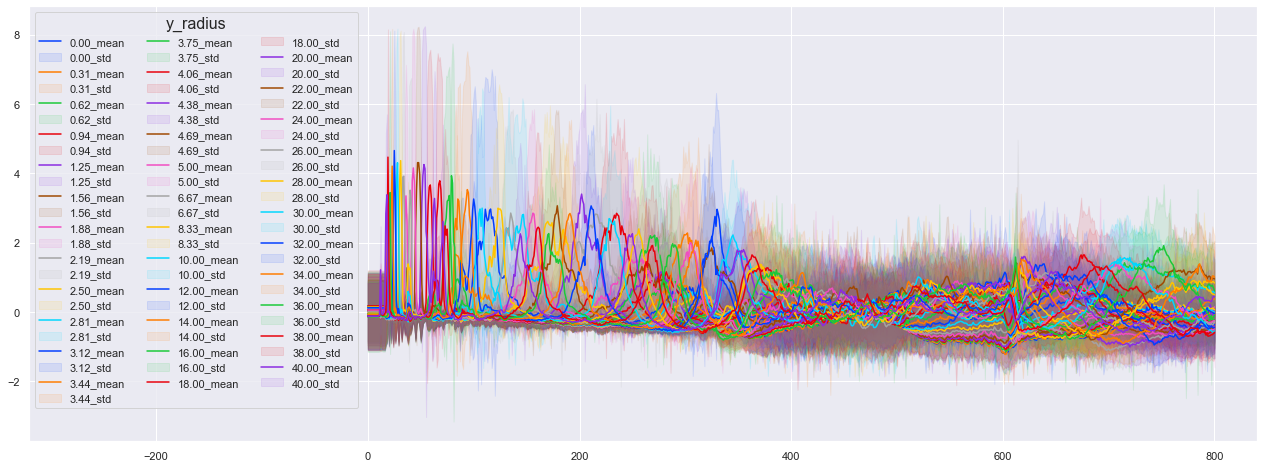

In [11]:
fig = plot_classwise_dist(df=df, label_col=target_col)
fig.gca().legend(ncol=3, loc='best', title=target_col)
fig.get_axes()[0].set(xlim=(-320, None));

### Focus on the first few features
It can be seen that only from index 17 upwards there is a clear separation of at least one target related distribution.

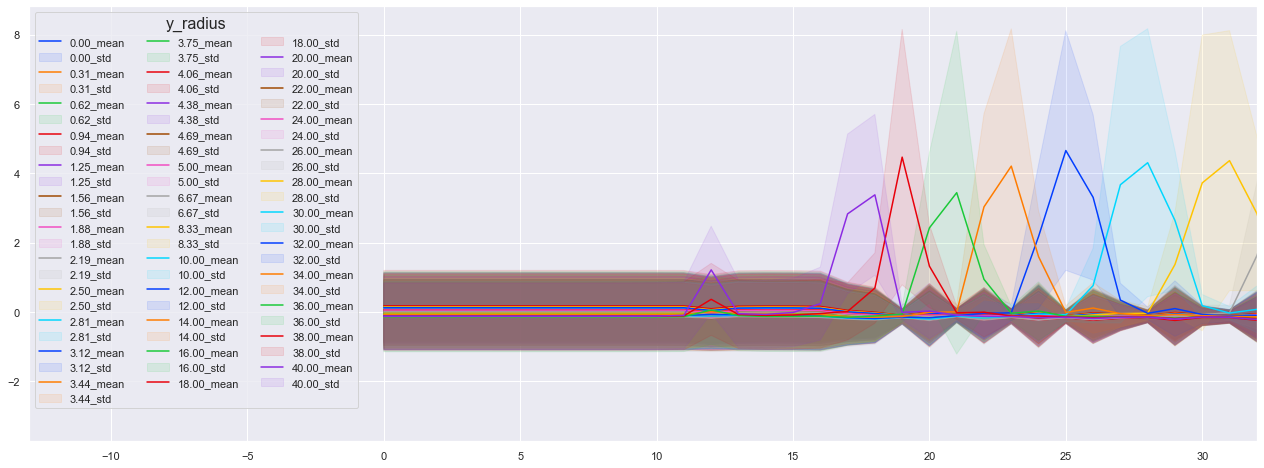

In [12]:
fig = plot_classwise_dist(df=df, label_col=target_col)
fig.gca().legend(ncol=3, loc='best', title=target_col)
fig.get_axes()[0].set(xlim=(-13, 32)); 

### Focus on the 17th feature distributions
As can be seen, the feature distribution with respect to the defect radius of 40 mm is clearly different compared to the remaining feature distributions.

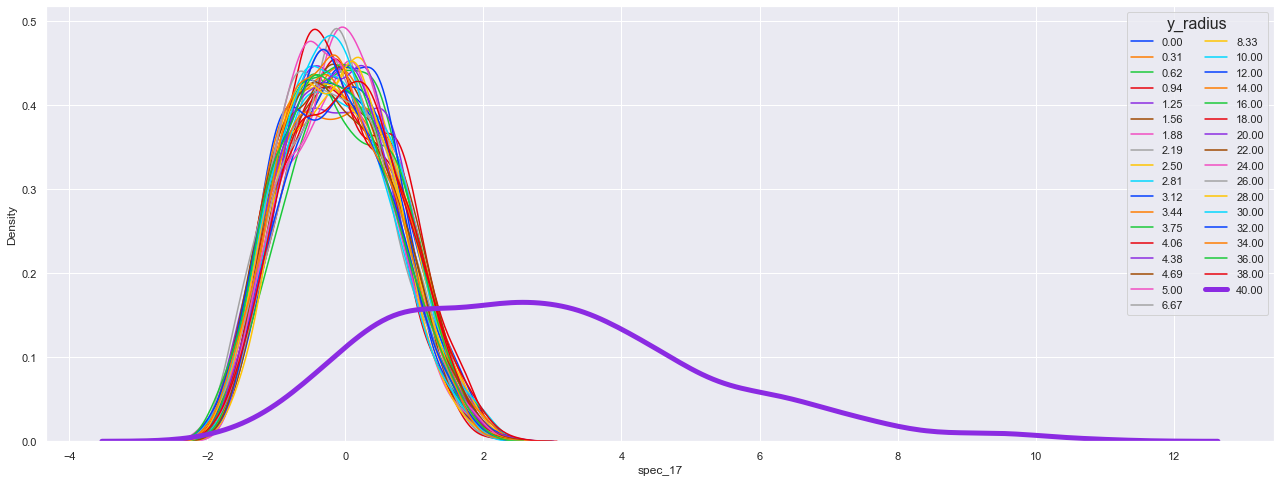

In [13]:
cntr = Counter(df[target_col])
labels = list(cntr.keys())
palette = sns.color_palette("bright", len(cntr.keys()))

fig = plot_classwise_kde(df=df,
                         label_col=target_col,
                         labels=labels,
                         palette=palette,                         
                         feature_idx=17,
                         focus=34)
fig.gca().legend(ncol=2, loc='best', title=target_col);

## Plot t-sne embedding

### convert to numpy array

In [14]:
X = df[feature_cols[17:]].values
y = df[target_col].values

X.shape

(34152, 784)

In [15]:
X_embedded = tsne_embedding(X, perplexity=40)

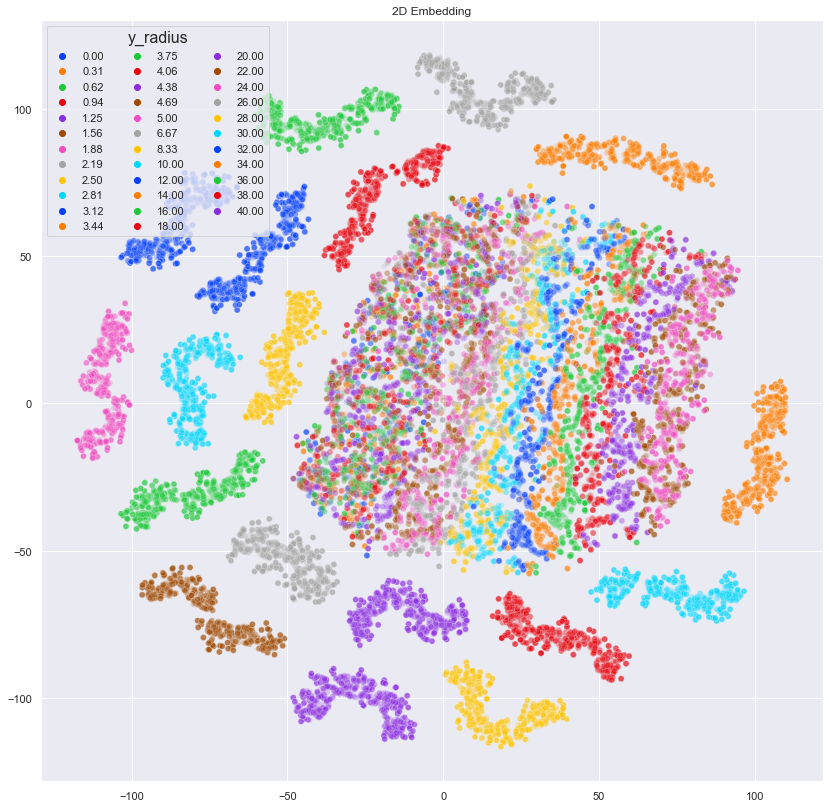

In [16]:
fig = plot_embedding_targets(X_embedded, y, alpha=0.2, palette=palette)
fig.set_size_inches((14, 14))
plt.title("2D Embedding")
legend = plt.legend(ncol=3, loc="upper left")
legend.set_title(target_col)
    
# format legend entries
for text in legend.get_texts():
    text.set_text(f"{float(text.get_text()):.2f}")
